In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from torchvision.utils import save_image


In [2]:
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    device = torch.device("cpu")
    print("GPU is not available")

PyTorch Version: 2.2.1
CUDA Device: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA Compute Capability: 8.9
Total Memory: 15.70 GB


## MNIST Dataset

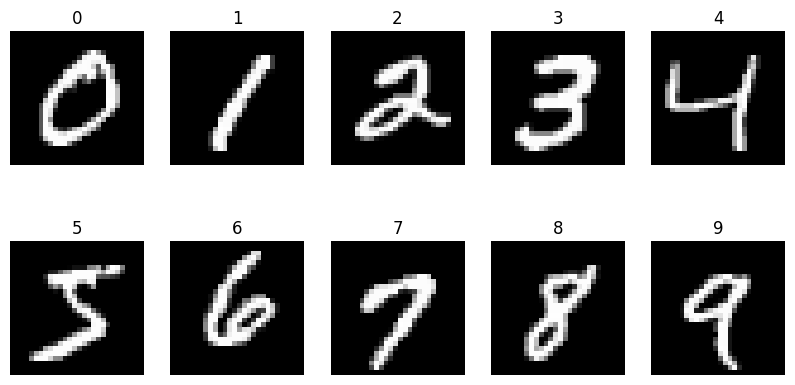

In [4]:
# load MNIST dataset from utils
from utils import get_dataset

(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(
        train_MNIST_dataset.data[train_MNIST_dataset.targets == i][0], cmap="gray"
    )
    ax.set_title(f"{i}")
    ax.axis("off")

In [5]:
from utils import get_network

ConvNet3 = get_network('ConvNetD3', channel, num_classes, im_size)
print(ConvNet3)

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)


In [ ]:
n_epochs = 4
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr)

for epoch in range(n_epochs):
    ConvNet3.train()
    running_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_MNIST_dataloader, 0),
        total=len(train_MNIST_dataloader),
        desc=f"Epoch {epoch+1}",
    )

    total_iterations = len(train_MNIST_dataloader)
    for i, data in enumerate(train_MNIST_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = ConvNet3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        percentage_complete = (i + 1) / total_iterations * 100
        progress_bar.set_postfix(loss=running_loss / (i + 1))
        progress_bar.update(1)



In [6]:
# report classification accuracy for test dataset
ConvNet3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in test_MNIST_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

### Dataset Distillation using Attention matching Algorithm

Portions of code used for attention matcching algorithm is taken from the following repository:

https://github.com/DataDistillation/DataDAM/

A. Sajedi, S. Khaki, E. Amjadian, L. Z. Liu, Y. A. Lawryshyn, and K. N. Plataniotis, DataDAM: Efficient Dataset Distillation with Attention Matching. 2023. [Online]. Available: https://arxiv.org/abs/2310.00093 



In [6]:
# learn synthetic dataset using Attention matching algorithm

""" organize the real dataset """
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [
    torch.unsqueeze(train_MNIST_dataset[i][0], dim=0)
    for i in range(len(train_MNIST_dataset))
]
labels_all = [train_MNIST_dataset[i][1] for i in range(len(train_MNIST_dataset))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

def get_images(c, n):  # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]


for c in range(num_classes):
    print("class\t%d:\t%d real images" % (c, len(indices_class[c])))
    
for ch in range(channel):
    print(
        "real images channel %d, mean = %.4f, std = %.4f"
        % (ch, torch.mean(images_all[:, ch]), torch.std(images_all[:, ch]))
    )

class	0:	5923 real images
class	1:	6742 real images
class	2:	5958 real images
class	3:	6131 real images
class	4:	5842 real images
class	5:	5421 real images
class	6:	5918 real images
class	7:	6265 real images
class	8:	5851 real images
class	9:	5949 real images
real images channel 0, mean = -0.0001, std = 1.0000


In [7]:
ipc = 5

In [8]:
""" Initialize the synthetic dataset """
images_syn = torch.randn(
    size=(num_classes*ipc, channel, im_size[0], im_size[1]),
    dtype=torch.float,
    requires_grad=True,
    device=device,
)

# Convert list of numpy arrays to a single numpy array
labels_array = np.array([np.ones(ipc) * c for c in range(num_classes)])

# Convert numpy array to tensor
labels_syn = torch.tensor(
    labels_array,
    dtype=torch.long,
    requires_grad=False,
    device=device,
).view(-1)

# Initialize synthetic dataset using real images
for c in range(num_classes):
    real_images = get_images(c, ipc)
    images_syn.data[c*ipc:(c+1)*ipc] = real_images.data

# print details of synthetic dataset, size and all
print(images_syn.size())
print(labels_syn.size())

torch.Size([50, 1, 28, 28])
torch.Size([50])


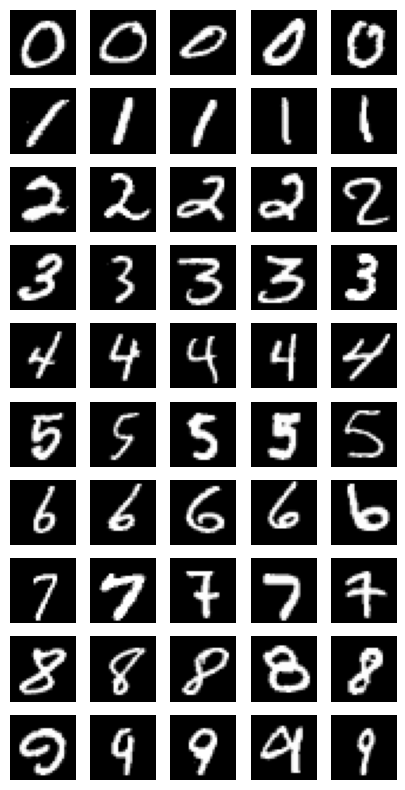

In [9]:
# plot all images_syn
fig, axes = plt.subplots(num_classes, ipc, figsize=(ipc, num_classes))
for i in range(num_classes):
    for j in range(ipc):
        axes[i, j].imshow(images_syn[i * ipc + j][0].cpu().detach().numpy(), cmap="gray")
        axes[i, j].axis("off")
#save the plot
plt.savefig("images_syn.png")

In [11]:
""" Train the synthetic dataset using Attention Matching Algorithm """
from utils import get_attention, TensorDataset, epoch
import copy


def learn_syn_dataset(
    channel,
    num_classes,
    im_size,
    images_syn,
    ipc,
    K=100,
    iterations=50,
    lr_img=0.01,
    minibatch_size=256,
    task_balance=0.01,
    batch_real=128,
    batch_train=128,
    zeta_theta=50
):
    optimizer_img = torch.optim.SGD([images_syn, ], lr_img, momentum=0.5) # optimizer_img for synthetic data
    optimizer_img.zero_grad()
    criterion = torch.nn.CrossEntropyLoss().to(device)

    for k in range(K):
        net = get_network('ConvNetD3', channel, num_classes, im_size).to(device)
        net.train() 
        for param in list(net.parameters()):
            param.requires_grad = False
            
        # Optimizer for the model
        optimizer_net = torch.optim.SGD(net.parameters(), lr=0.01)
        optimizer_net.zero_grad()
        
        activations = {}
        def getActivation(name):
            def hook_func(m, inp, op):
                activations[name] = op.clone()
            return hook_func

        ''' Defining the Refresh Function to store Activations and reset Collection '''
        def refreshActivations(activations):
            model_set_activations = [] # Jagged Tensor Creation
            for i in activations.keys():
                model_set_activations.append(activations[i])
            activations = {}
            return activations, model_set_activations

        ''' Defining the Delete Hook Function to collect Remove Hooks '''
        def delete_hooks(hooks):
            for i in hooks:
                i.remove()
            return
                    
        def attach_hooks(net):
            hooks = []
            base = net.module if torch.cuda.device_count() > 1 else net
            for module in (base.features.named_modules()):
                if isinstance(module[1], nn.ReLU):
                    # Hook the Ouptus of a ReLU Layer
                    hooks.append(base.features[int(module[0])].register_forward_hook(getActivation('ReLU_'+str(len(hooks))),))
            return hooks
        
        for it in range(iterations+1) :
            ''' visualize and save '''
            save_name = f"images_syn_{it}.png"
            image_syn_vis = copy.deepcopy(images_syn.detach().cpu())
            for ch in range(channel):
                image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
            image_syn_vis[image_syn_vis<0] = 0.0
            image_syn_vis[image_syn_vis>1] = 1.0
            save_image(image_syn_vis, save_name, nrow=ipc) # Trying normalize = True/False may get better visual effects.


            
            loss_avg = 0
            def error(real, syn, err_type="MSE"):          
                if(err_type == "MSE"):
                    err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0))**2)
                            
                elif (err_type == "MAE"):
                    err = torch.sum(torch.abs(torch.mean(real, dim=0) - torch.mean(syn, dim=0)))
                                
                elif (err_type == "ANG"):
                    rl = torch.mean(real, dim=0) 
                    sy = torch.mean(syn, dim=0)
                    num = torch.matmul(rl, sy)
                    denom = (torch.sum(rl**2)**0.5) * (torch.sum(sy**2)**0.5)
                    err = torch.acos(num/denom)
                                
                elif (err_type == "MSE_B"):
                    err = torch.sum((torch.mean(real.reshape(num_classes, batch_real, -1), dim=1).cpu() - torch.mean(syn.cpu().reshape(num_classes, ipc, -1), dim=1))**2)
                elif (err_type == "MAE_B"):
                    err = torch.sum(torch.abs(torch.mean(real.reshape(num_classes, batch_real, -1), dim=1).cpu() - torch.mean(syn.reshape(num_classes, ipc, -1).cpu(), dim=1)))
                elif (err_type == "ANG_B"):
                    rl = torch.mean(real.reshape(num_classes, batch_real, -1), dim=1).cpu()
                    sy = torch.mean(syn.reshape(num_classes, ipc, -1), dim=1)
                                
                    denom = (torch.sum(rl**2)**0.5).cpu() * (torch.sum(sy**2)**0.5).cpu()
                    num = rl.cpu() * sy.cpu()
                    err = torch.sum(torch.acos(num/denom))
                return err
            
            # update the synthetic dataset
            loss = torch.tensor(0.0, device=device)
            mid_loss = 0
            out_loss = 0
            
            images_real_all = []
            images_syn_all = []
            
            for c in range(num_classes):
                img_real = get_images(c, ipc)
                img_syn = images_syn[c * ipc : (c + 1) * ipc].reshape(ipc, channel, im_size[0], im_size[1])
                
                images_real_all.append(img_real)
                images_syn_all.append(img_syn)
                
            images_real_all = torch.cat(images_real_all, dim=0)    
            images_syn_all = torch.cat(images_syn_all, dim=0)
            
            hooks = attach_hooks(net)
            outputs_real = net(images_real_all)[0].detach()
            activations, orig_model_set_activations = refreshActivations(activations)
            
            output_syn = net(images_syn_all)[0]
            activations, syn_model_set_activations = refreshActivations(activations)
            delete_hooks(hooks)
            
            length_of_network = len(orig_model_set_activations)
            
            for layer in range(length_of_network - 1):
                real_attentions = get_attention(orig_model_set_activations[layer], param=1, exp=1, norm='l2')
                syn_attentions = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')
                
                tl = 100*error(real_attentions, syn_attentions, err_type="MSE")
                loss += tl
                mid_loss += tl
                
            output_loss = 100*task_balance*error(outputs_real, output_syn, err_type="MSE")
            
            loss += output_loss
            out_loss += output_loss
            
            optimizer_img.zero_grad()
            loss.backward()
            optimizer_img.step()
            loss_avg += loss.item()
            torch.cuda.empty_cache()


        
        print(f"Loss: {loss_avg:.4f}, Output Loss: {out_loss:.4f}, Mid Loss: {mid_loss:.4f}")
        
            
learn_syn_dataset(
    channel,
    num_classes,
    im_size,
    images_syn,
    ipc = 5,
    iterations=10,
    minibatch_size=256,
    task_balance=0.01,
)

Loss: 0.9221, Output Loss: 0.0003, Mid Loss: 0.9218
Loss: 0.6360, Output Loss: 0.0031, Mid Loss: 0.6329
Loss: 1.1536, Output Loss: 0.0064, Mid Loss: 1.1472
Loss: 0.7034, Output Loss: 0.0001, Mid Loss: 0.7033
Loss: 0.5879, Output Loss: 0.0004, Mid Loss: 0.5875
Loss: 0.8417, Output Loss: 0.0021, Mid Loss: 0.8395
Loss: 1.0221, Output Loss: 0.0058, Mid Loss: 1.0163
Loss: 0.6604, Output Loss: 0.0009, Mid Loss: 0.6595
Loss: 1.0989, Output Loss: 0.0000, Mid Loss: 1.0989
Loss: 0.5309, Output Loss: 0.0011, Mid Loss: 0.5298
Loss: 0.6586, Output Loss: 0.0000, Mid Loss: 0.6586
Loss: 0.7326, Output Loss: 0.0014, Mid Loss: 0.7312
Loss: 0.9307, Output Loss: 0.0018, Mid Loss: 0.9289
Loss: 0.8226, Output Loss: 0.0000, Mid Loss: 0.8226
Loss: 1.1409, Output Loss: 0.0007, Mid Loss: 1.1402
Loss: 0.7829, Output Loss: 0.0016, Mid Loss: 0.7813
Loss: 0.6503, Output Loss: 0.0000, Mid Loss: 0.6503
Loss: 0.7437, Output Loss: 0.0014, Mid Loss: 0.7423
Loss: 0.7047, Output Loss: 0.0001, Mid Loss: 0.7046
Loss: 1.2720

In [ ]:
# plot all images_syn
fig, axes = plt.subplots(num_classes, ipc, figsize=(ipc, num_classes))
for i in range(num_classes):
    for j in range(ipc):
        axes[i, j].imshow(images_syn[i * ipc + j][0].cpu().detach().numpy(), cmap="gray")
        axes[i, j].axis("off")
        
#save the plot
plt.savefig("images_syn2.png")

In [ ]:
""" Train the synthetic dataset using Attention Matching Algorithm """
from utils import get_attention

optimizer_img = torch.optim.SGD([images_syn], lr=0.1, momentum=0.9)
optimizer_img.zero_grad()

loss = torch.tensor(0.0, device=device)

images_real_all = []
images_syn_all = []

for c in range(num_classes):
    img_real = get_images(c, minibatch_size)
    img_sync = images_syn[c * imgs_per_class : (c + 1) * imgs_per_class].reshape(
        (imgs_per_class, channel, im_size[0], im_size[1])
    )

    images_real_all.append(img_real)
    images_syn_all.append(img_sync)

images_real_all = torch.cat(images_real_all, dim=0)
images_syn_all = torch.cat(images_syn_all, dim=0)

hooks = attach_hooks(ConvNet3)
output_real = ConvNet3(images_real_all).detach()
activations, original_model_set_activations = refreshActivations(activations)


output_syn = ConvNet3(images_syn_all).detach()
activations, synthetic_model_set_activations = refreshActivations(activations)
delete_hooks(hooks)

print("output_real", output_real.size())
print("output_syn", output_syn.size())

length_of_network = len(original_model_set_activations)
for i in range(length_of_network):
    real_attention = get_attention(original_model_set_activations[i].detach(), param=1, exp=1, norm='l2')
    syn_attention = get_attention(synthetic_model_set_activations[i].detach(), param=1, exp=1, norm='l2')

    tl = 100*error(real_attention, syn_attention, err_type="MSE")
    loss += tl

output_loss = 100*task_balance*error(output_real, output_syn, err_type="MSE")
loss += output_loss

optimizer_img.zero_grad()
loss.backward()
optimizer_img.step()
torch.cuda.empty_cache()

In [ ]:
# display output_syn images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(output_syn[i][0].cpu().detach().numpy(), cmap="gray")
    ax.axis("off")

## MHIST Dataset

In [ ]:
# load MHIST dataset from MHISTDataset class
import MHISTDataset

train_MHIST_dataset = MHISTDataset.MHISTDataset('../mhist_dataset/images-split/train', transform=None)
test_MNIST_dataset = MHISTDataset.MHISTDataset('../mhist_dataset/images-split/test', transform=None)

# find train_MHIST_dataset with "HP" label, train_MHHIST_dataset[i][2]
HP_indices = [i for i in range(len(train_MHIST_dataset)) if train_MHIST_dataset[i][2] == 'HP']
SSA_indices = [i for i in range(len(train_MHIST_dataset)) if train_MHIST_dataset[i][2] == 'SSA']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(train_MHIST_dataset[HP_indices[0]][0])
axes[0].set_title("HP")
axes[0].axis('off')
axes[1].imshow(train_MHIST_dataset[SSA_indices[0]][0])
axes[1].set_title("SSA")
axes[1].axis('off')
plt.show()

### ConvNet3 Model